* Load data
* Build Generator
* Discriminator
* Training Loop

CNN in Generator, Classifier for Discriminator

# 1. Import dependencies

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [3]:
# for fashion-mnist
import tensorflow_datasets as tfds
# for visualisation
from matplotlib import pyplot as plt

In [4]:
# use tfds api to load fashion-mnist
# pipeline for repeatable calls to bring data back
# has to sset a iterator to continously call to bring data
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.CO1KTT_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.CO1KTT_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
type(ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [6]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Data

In [7]:
# for data transformation
import numpy as np

In [8]:
# set up connections for pipelines
dataiterator = ds.as_numpy_iterator()

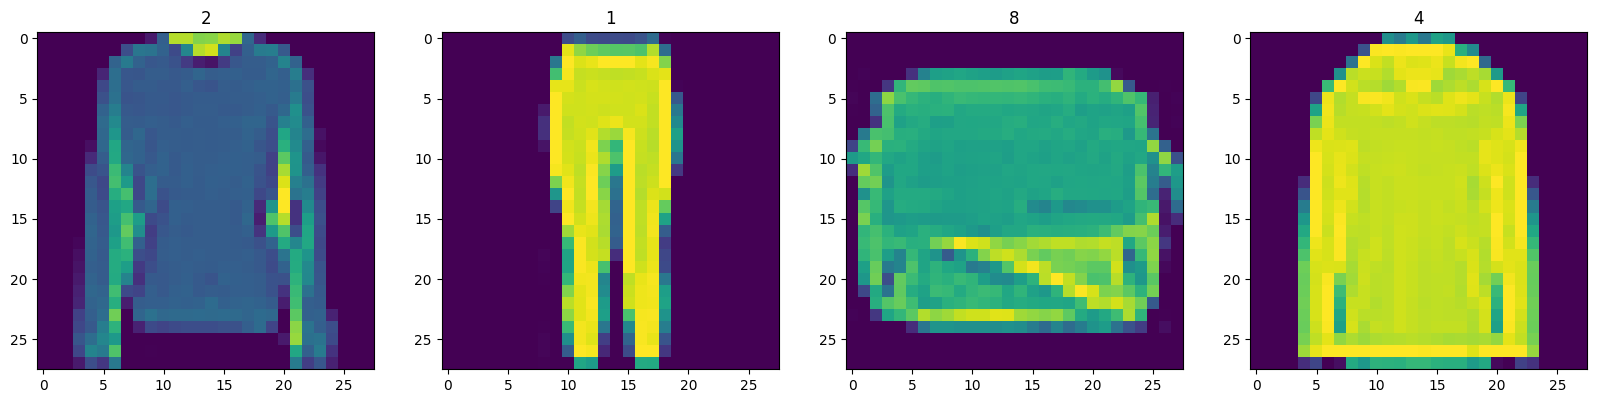

In [9]:
# create plots
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
#loop 4 times and get images
for idx in range(4):
    batch = dataiterator.next() # one sample (images, dict)
    ax[idx].imshow(np.squeeze(batch['image'])) # squeeze to change shape of image
    # appending image label on plot
    ax[idx].title.set_text(batch['label'])

### Data pipeline structure for tf
map  
cache  
shuffle  
batch  
prefetch

In [10]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255


In [11]:
ds = tfds.load('fashion_mnist', split='train')
# Scalling all images
ds = ds.map(scale_images)
# Caching the data
ds = ds.cache()
# shuffling it, size = 60k, test =10k, train = 50k
ds = ds.shuffle(60000)
# make batch of 128
ds = ds.batch(128)
# eliminate bottleneck likelihood
ds = ds.prefetch(64)

In [12]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Neural Network

#### 3.1 import modelling components

In [13]:
# bring sequential api for genrator ans deiscriminator
from tensorflow.keras.models import Sequential
# Layers for NN
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D 

#### 3.2 Generator

In [14]:
def build_generator():
    model = Sequential()
    # FC layer, takes random 
    # Start of genrated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    
    # 2D conv
    model.add(Reshape((7,7,128)))
    
    # Unsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to final channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
                        
    return model

In [15]:
generator= build_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
img = generator.predict(np.random.rand(4,128,1))
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[[[0.49652746],
         [0.49674115],
         [0.499339  ],
         ...,
         [0.5018895 ],
         [0.5019826 ],
         [0.49952492]],

        [[0.5002084 ],
         [0.4992983 ],
         [0.50304097],
         ...,
         [0.5060735 ],
         [0.5048918 ],
         [0.5014582 ]],

        [[0.49665993],
         [0.4941948 ],
         [0.49680877],
         ...,
         [0.50776225],
         [0.5054799 ],
         [0.5023075 ]],

        ...,

        [[0.4977464 ],
         [0.49913436],
         [0.49757883],
         ...,
         [0.5007812 ],
         [0.5006839 ],
         [0.50100553]],

        [[0.49883032],
         [0.49672717],
         [0.49528474],
         ...,
         [0.49969703],
         [0.5011525 ],
         [0.5007509 ]],

        [[0.4981212 ],
         [0.4986772 ],
         [0.5002411 ],
         ...,
         [0.49990562],
         [0.5006435 ],
         [0.5001565 ]]],


       [[[0.49562666],
         [0.49941924],
         [0.50

In [18]:
img.shape

(4, 28, 28, 1)

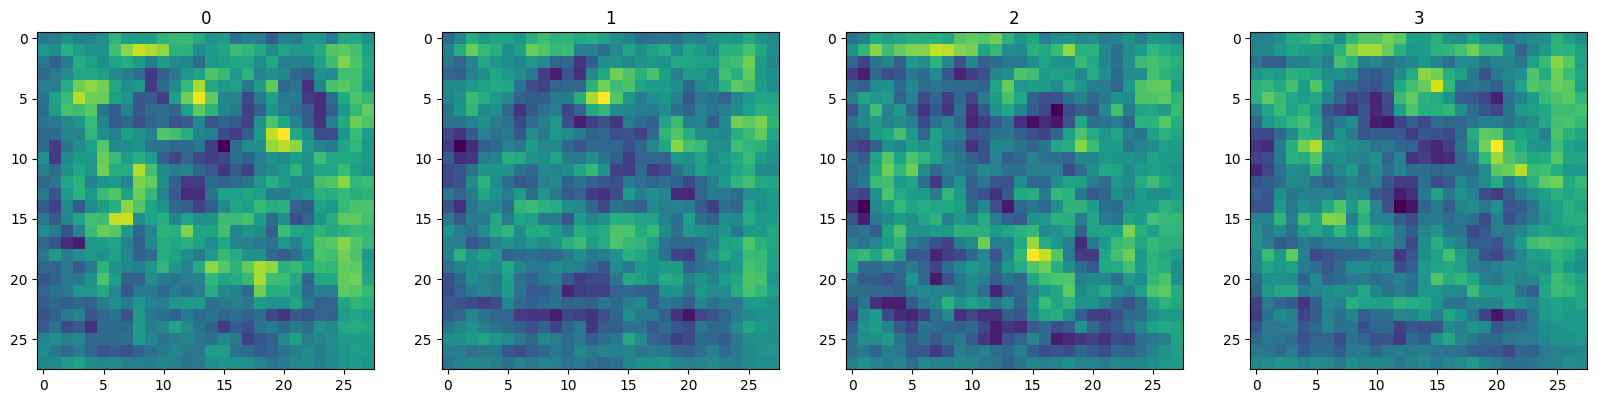

In [19]:
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

#### 3.3 Build Discriminator

In [20]:
def build_discriminator():
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) # harder for model to learn
    #Block2
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4) )# harder for model to learn
    #block3
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) # harder for model to learn
    #block4
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) # harder for model to learn

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))

    return model

In [21]:
discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
img.shape

(28, 28, 1)

In [23]:
discriminator.predict(np.expand_dims(img,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


array([[0.49540198]], dtype=float32)

# 4. Construct Training Loop

#### 4.1 Setup Losses & Optimizers

In [24]:
# Same for both genrator and discriminator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [25]:
g_opt = Adam(learning_rate=0.0004)
d_opt = Adam(learning_rate=0.00005)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### 4.2 Build Subclassed Model

In [26]:
#imprting base class to subclass
from tensorflow.keras.models import Model

In [27]:
tf.concat([tf.zeros_like(tf.random.normal((6,128))), tf.ones_like(tf.random.normal((6,128)))], axis=0)

<tf.Tensor: shape=(12, 128), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

In [28]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        #pass through args and kward to base class(parent)
        super().__init__(*args, **kwargs)

        # create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
        
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        #compile with base class
        super().compile(*args, **kwargs)
       
        # attr for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    def train_step(self, batch):
        # get the batch of data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # pass the real and fake images to the discriminator
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake =tf.concat([yhat_real, yhat_fake], axis=0)
            
            # create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # add some noise to the outputs (Add confusion to discriminators)
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
    
            # calulate loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)    
                
        # apply backprop
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # TRAIN THE GENERATOR
        with tf.GradientTape() as g_tape:
            # Generate new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training = False)

            # Calucalte Losses - (TRICK TO TRAINING TO FAKE OUT THE DISCRIMINATOR)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
        #Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [29]:
#@tf.function
#def train_step():
    

In [30]:
# instance of model
fashiongan = FashionGAN(generator, discriminator)

In [31]:
# compile our model
fashiongan.compile(g_opt, d_opt, g_loss, d_loss)

#### Build Callback

In [32]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [33]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_dir = '/kaggle/working/images'
        os.makedirs(self.save_dir, exist_ok=True)  

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images = generated_images.numpy()

        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join(self.save_dir, f'generated_img{epoch}_{i}.png'))

#### 4.3 Train

In [34]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [35]:
# Recommend ~ 2000
hist = fashiongan.fit(ds, epochs = 20, callbacks = [ModelMonitor()])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 129s 225ms/step - d_loss: 0.3229 - g_loss: 4.2571
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - d_loss: 0.2706 - g_loss: 3.9094
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - d_loss: 0.2691 - g_loss: 3.3962
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - d_loss: 0.2681 - g_loss: 3.0665
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - d_loss: 0.2677 - g_loss: 2.7564
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - d_loss: 0.2676 - g_loss: 2.5407
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 203ms/step - d_loss: 0.3149 - g_loss: 2.6378
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 203ms/step - d_loss: 0.2688 - g_loss: 2.9399
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 202ms/step - d_loss: 0.2676 - g_loss: 3.0005
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 202ms/step - d_loss: 0.2674 - g_loss: 3.0263
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 202ms/step - d_loss: 0.2679 - g_loss: 2.9991
Epoch 12/20
469/46

#### 4.4 Review Performance

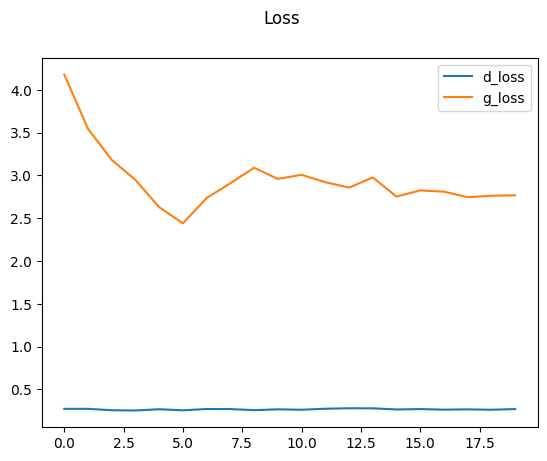

In [36]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()# Scale and return images only 



# 5. Test out Generator

#### 5.1 Generate Images

In [38]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


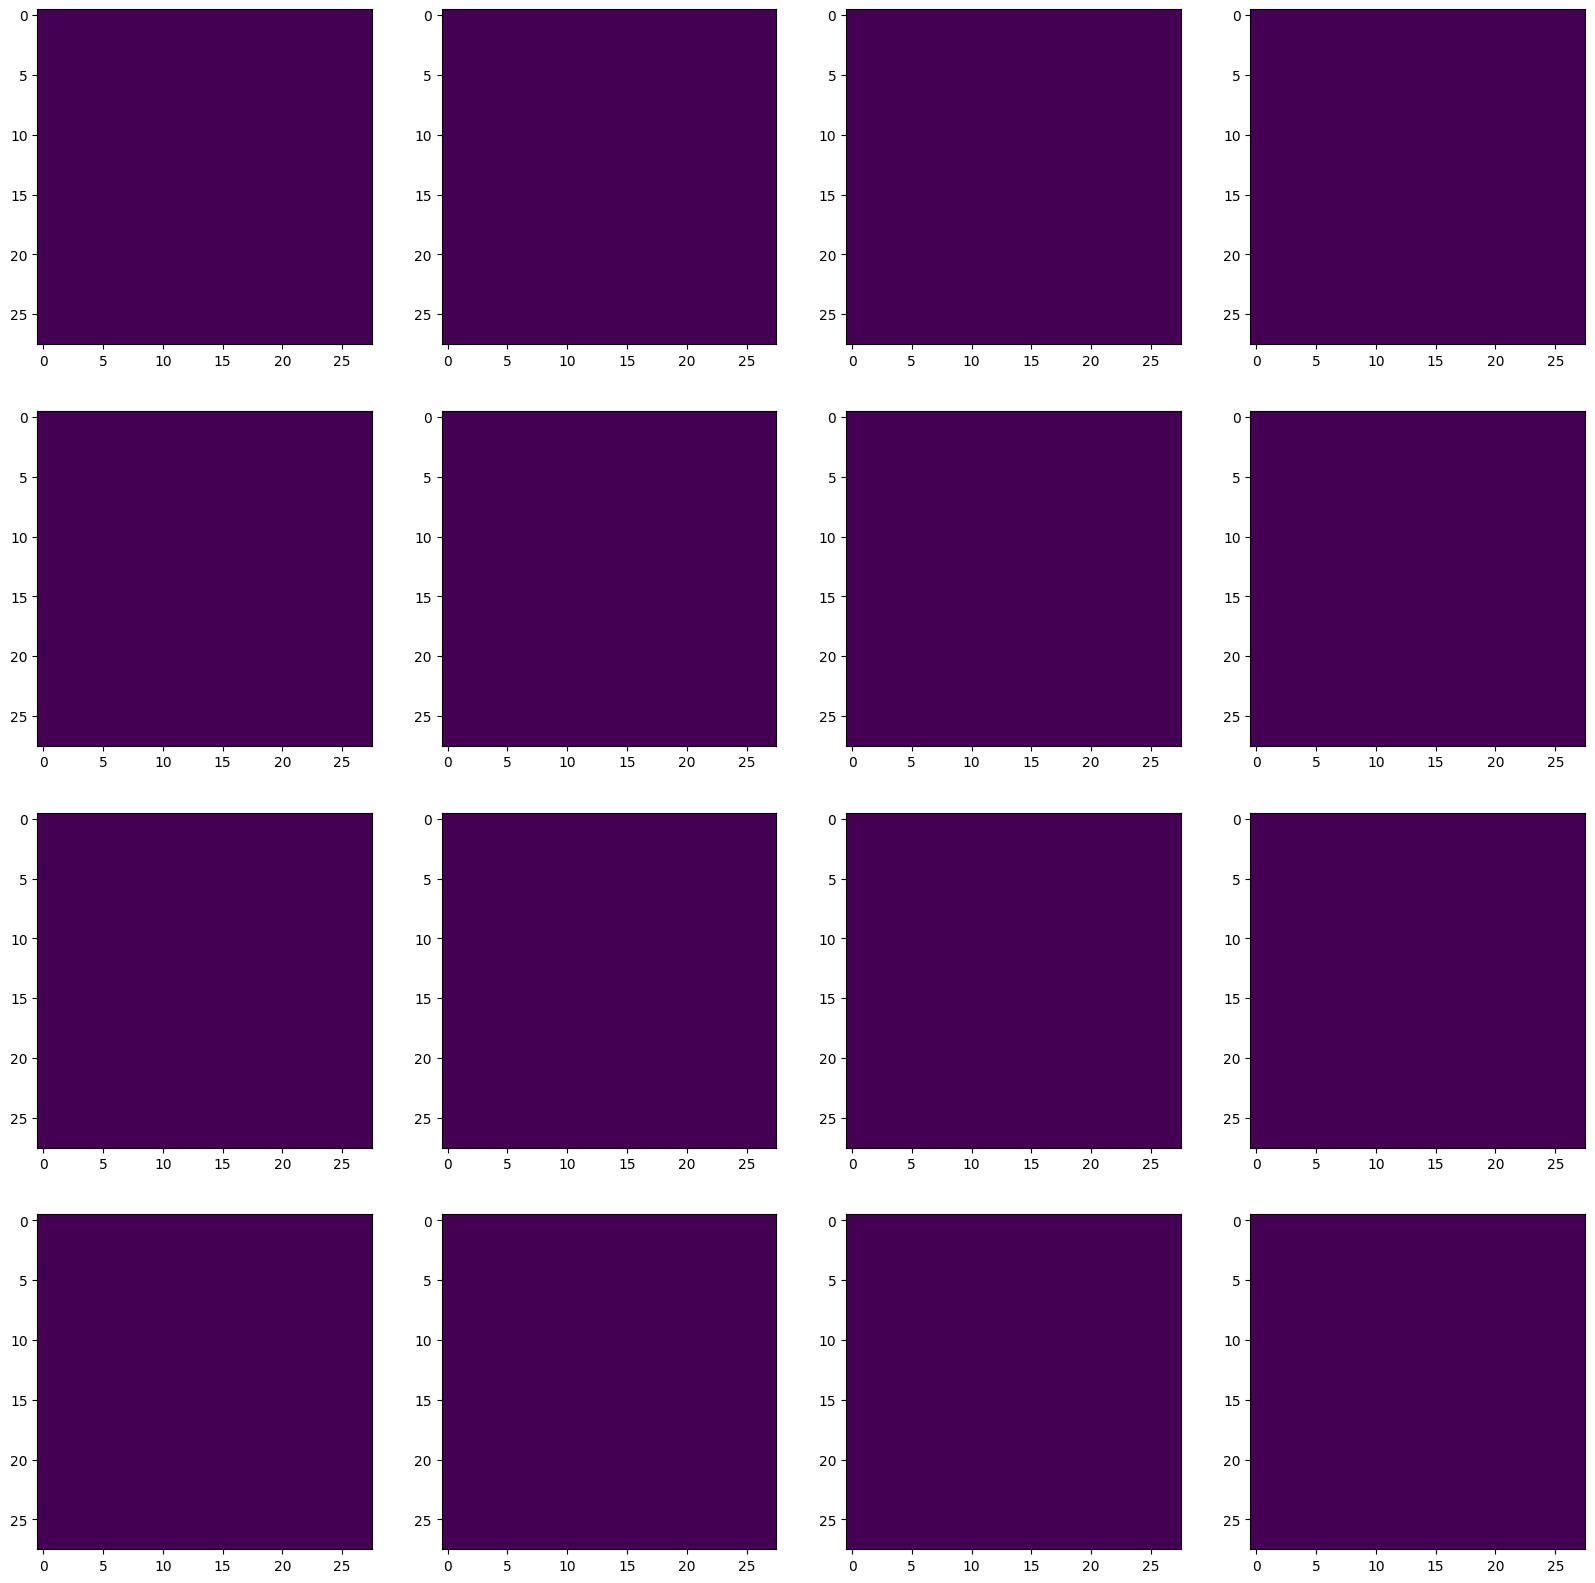

In [40]:
figs, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
generator.save('generator.h5')
dicriminator.save('discriminator.h5')